# Option

In [2]:
from numba import njit
import numpy as np
from warnings import filterwarnings

filterwarnings("ignore")

@njit
def sample_wiener_process_one_path(
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates one realization of a Wiener process (Brownian motion).

      Parameters:
      - time_deltas (np.ndarray): Array of time intervals between grid points = np.diff(time_grid).
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array representing the generated Wiener process path.

      Note: This function utilizes the `numba` library's JIT (Just-In-Time) compilation for improved
      performance. Ensure `numba` is installed in your environment.
    """
    normals = np.random.normal(0, sigma, len(time_deltas))
    result = np.zeros(len(time_deltas) + 1, dtype=float)
    result[1:] = np.cumsum(normals * np.sqrt(time_deltas))
    return result


@njit
def sample_wiener_process(
        number_of_simulations: int,
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates some realizations of a Wiener process (Brownian motion).

      Parameters:
      - number_of_simulations (int): number of paths to generate
      - time_deltas (np.ndarray): Array of time intervals between successive observations.
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array, each row representing the generated Wiener process trajectory.
    """
    result = np.zeros((number_of_simulations, len(time_deltas) + 1), dtype=float)
    for i in range(number_of_simulations):
        result[i] = sample_wiener_process_one_path(time_deltas, sigma)
    return result


def transform_to_monomials_degree_3(
        x: np.ndarray
) -> np.ndarray:
    """
      Transforms input features to all monomials degree <= 3

      Parameters:
      - x (np.ndarray): Input feature matrix of shape (n_samples, n_features).

      Returns:
      - transformed (np.ndarray): Array to store the transformed features, shape (n_samples, (n_features + 1) * (n_features + 2) // 2).
    """
    index = 0
    transformed = np.zeros((x.shape[0],
                            (x.shape[1] + 1) * (x.shape[1] + 2) // 2 + (x.shape[1] + 1) * (x.shape[1] + 2) * (
                                    x.shape[1] + 3) // 6
                            ), dtype=float)
    # triple-wise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            for k in range(j, x.shape[1]):
                transformed.T[index] = x.T[i] * x.T[j] * x.T[k]
                index += 1
    # pairwise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            transformed.T[index] = x.T[i] * x.T[j]
            index += 1
    # repeat features
    for i in range(x.shape[1]):
        transformed.T[index] = x.T[i]
    # constant feature
    transformed.T[-1] = 1.
    return transformed


def f(
        assets0: np.ndarray,
) -> float:
    """
      Calculates bermudan call option with underlying max(asset_1, asset_2, ...) and strike_t = 0, asset_i --- Wiener process

      Parameters:
      - assets0 (np.ndarray): assets at the time 0
      Returns:
      float: option price

      time_grid = np.linspace(0., 1., 31)
      sigmas = 10.
      number_of_simulations = 2 ** 13
      strike = 100.
    """
    # init
    number_of_simulations = 2 ** 13
    t = 10
    time_grid = np.array(list(range(365 * t + 1)))
    time_grid = time_grid[np.where(np.logical_or(time_grid % 7 == 1, time_grid % 7 == 0))] / 365
    time_deltas = np.diff(time_grid)
    number_of_steps = len(time_deltas)
    discount_rate = 0.1

    # sampling
    discount_factor = np.exp(-discount_rate * time_grid)
    strike = np.ones(number_of_steps + 1, dtype=float) * 100. * discount_factor
    number_of_assets = len(assets0)
    sigmas = np.ones_like(assets0, dtype=float) * 10.
    assets = np.zeros((number_of_assets, number_of_simulations, number_of_steps + 1), dtype=float)
    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    # AMC
    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    regularization_alpha = 1e-2
    weights = [None] * (number_of_steps + 1)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            regularization = np.eye(transformed.shape[1], dtype=float) * regularization_alpha
            inv = np.linalg.pinv((transformed.T @ transformed + regularization), rcond=1e-4)
            weights[time_index] = inv @ transformed.T @ option_price[in_the_money_indices].reshape(-1, 1)
            continuation_value = transformed @ weights[-1]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20 or weights[time_index] is None:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            continuation_value = transformed @ weights[time_index]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    return np.array([np.mean(option_price)])

In [3]:
import sys
sys.path.append("..")
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
import random 
from gale.doe import SeqED, adaptive_sampling
from gale.experiments import bench_functions as bf

import time
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
l_bounds = [40.,]
u_bounds = [160.,]
sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=100)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
X_grid = np.array(sample_scaled)


# train_points = []
# train_answers = []
# for i in X_grid:
#     train_points.append(i)
#     train_answers.append(f(i))

# sampler = qmc.LatinHypercube(d=1)
# sample = sampler.random(n=1000)
# sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
# X_grid = np.array(sample_scaled)


# test_points = []
# test_answers = []
# for i in X_grid:
#     test_points.append(i)
#     test_answers.append(f(i))

# np.save('X_train_new', train_points)
# np.save('y_train_new', train_answers)

# np.save('X_test_new', test_points)
# np.save('y_test_new', test_answers)

In [6]:
np.random.seed(seed=1)
idx = np.random.randint(0,100,4)

In [7]:
idx

array([37, 12, 72,  9])

In [97]:
train_points = np.load('X_train_new.npy')[idx]
train_answers = np.load('y_train_new.npy')[idx]

test_points = np.load('X_test_new.npy')
test_answers = np.load('y_test_new.npy')

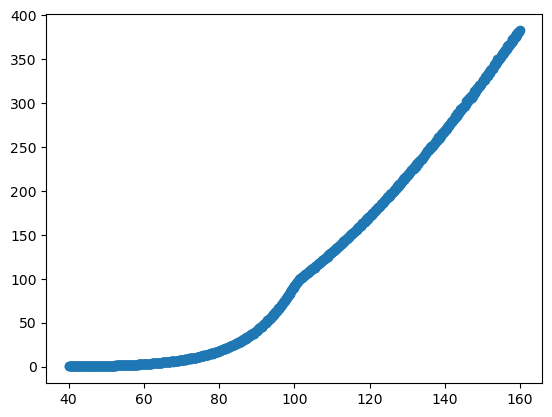

In [9]:
plt.scatter(test_points,test_answers)

In [20]:
n_i=len(train_points)
bounds=[[40., 160.]]
n_c = n_i+30
ncalls = n_i+30

In [22]:
inference_time = {}
mse = {}
r2 = {}

In [24]:
# test_answers_ = []
# start = time.time()
# for i in test_points:
#     test_answers_.append(f(i))
# end = time.time()

# time_ = end-start
# mse_ = mean_squared_error(test_answers_,test_answers)
# r2_ = r2_score(test_answers_,test_answers)

# inference_time['Fact'] = [time_]
# mse['Fact'] = [mse_]
# r2['Fact'] = [r2_]

# GP

In [27]:
seed = 31

MSE = {}
RMSE = {}
MAE = {}
R2 = {}
Time = {}

MSE_var = {}
RMSE_var = {}
MAE_var = {}
R2_var = {}
Time_var = {}
pointss = {}
ms = []

In [29]:
for as_name in ['GUESS','wMMSE','MMSE','TEAD',]:
    MSE_ = []
    MAE_ = []
    R2_ = []
    Time_ = []
    Time_inf = []
    poiints = []

    for _ in range(1):

        if as_name == 'DL_ASED':
            method = adaptive_sampling[as_name](bounds=bounds,\
                                                n_init=n_i, rnd_state=seed, model="FITC",n_max = n_c,init_sampling = train_points)
        else:
            method = adaptive_sampling[as_name](bounds=bounds,\
                                                n_init=n_i, rnd_state=seed, model="GP",optimizer ="diff_evo",n_max = n_c,init_sampling = train_points,init_sampling_y = train_answers)

        doe = SeqED(fun=f, adaptive_method=method, n_calls=ncalls,verbose=1, eval_performance=1,bench_sampling = test_points,freq=1,\
                                                x=train_points,y=train_answers,y_true=test_answers)
        res = doe.run()
        
        MSE_.append(res['metrics'][0]['results'])
        MAE_.append(res['metrics'][1]['results'])
        R2_.append(res['metrics'][2]['results'])
        Time_.append(np.array(res['ask_time'][n_i:])+np.array(res['tell_time'][n_i:]))
        ms.append(res['model'])
        poiints.append(res['obs_cond'])
        #Time_inf.append(res['fun_time'][-1])

    MSE[as_name] = np.mean(MSE_,axis=0)
    pointss[as_name] = np.mean(poiints,axis=0).reshape(1,-1)
    MSE_var[as_name] = np.var(MSE_,axis=0)

    RMSE[as_name] = np.mean(np.sqrt(MSE_),axis=0)
    RMSE_var[as_name] = np.var(np.sqrt(MSE_),axis=0)
    
    MAE[as_name] = np.mean(MAE_,axis=0)
    MAE_var[as_name] = np.var(MAE_,axis=0)
    
    R2[as_name] = np.mean(R2_,axis=0)
    R2_var[as_name] = np.var(R2_,axis=0)
    
    Time[as_name] = np.mean(Time_,axis=0)
    Time_var[as_name] = np.var(Time_,axis=0)


####################
Start Adaptive Sampling:
Sampling Strategy: Gradient and Uncertainty Enhanced Sequential Sampling (GUESS)

Given Parameters:
------------------
Seed: 31
Verbose: False
Init. Sampling Number: 4
Bounds: [[40.0, 160.0]]
Init. Sampling: Given samples
Sampling on bounds: False
Optimizer: False

Used Surrogate Model: GP
------------------
####################

Simulate: [#---------] 8.82% MSE in iteration 4: 8559.31
MAE in iteration 4: 49.12
R2 in iteration 4: 0.41
Simulate: [#---------] 11.76% MSE in iteration 5: 133.66
MAE in iteration 5: 7.78
R2 in iteration 5: 0.99
Simulate: [#---------] 14.71% MSE in iteration 6: 8.75
MAE in iteration 6: 1.97
R2 in iteration 6: 1.00
Simulate: [##--------] 17.65% MSE in iteration 7: 8.23
MAE in iteration 7: 1.73
R2 in iteration 7: 1.00
Simulate: [##--------] 20.59% MSE in iteration 8: 8.09
MAE in iteration 8: 1.69
R2 in iteration 8: 1.00
Simulate: [##--------] 23.53% MSE in iteration 9: 8.53
MAE in iteration 9: 1.67
R2 in iteration 

In [30]:
MSE

{'GUESS': array([8.55931439e+03, 1.33656495e+02, 8.75290659e+00, 8.23088783e+00,
        8.09302856e+00, 8.52616555e+00, 1.05176827e+00, 1.04860730e+00,
        1.03937345e+00, 8.15055862e-01, 6.80226743e-01, 3.59236061e-01,
        3.59531413e-01, 3.91737882e-01, 4.02437694e-01, 3.99404206e-01,
        3.89443785e-01, 3.88917620e-01, 3.88643545e-01, 4.15261183e-01,
        3.74631656e-01, 3.68727519e-01, 3.66995512e-01, 4.75346245e-01,
        5.53445487e-01, 4.91850404e-01, 4.89386234e-01, 4.89334273e-01,
        5.16714085e-01, 5.11442264e-01, 5.08370779e-01]),
 'wMMSE': array([8.55931353e+03, 1.36882834e+02, 9.93740545e+00, 1.17609123e+01,
        6.02980253e+00, 6.52000512e+00, 1.25145302e+00, 1.45812288e+00,
        1.28938076e+00, 1.18467648e+00, 1.18293684e+00, 1.21345079e+00,
        7.41647467e-01, 7.21909428e-01, 7.21025320e-01, 8.67154038e-01,
        8.59104300e-01, 8.36374889e-01, 8.29794654e-01, 7.63491924e-01,
        7.65263512e-01, 7.63539004e-01, 7.56908909e-01, 7.55

In [31]:
d = ['GP GUESS','GP wMMSE','GP MMSE','GP TEAD'] 
test_answers = test_answers.reshape((-1,1))
i=0
for m in ms:
    start = time.time()
    preds = m.predict(test_points)
    end = time.time()
    time_ = end-start
    mse_ = mean_squared_error(preds,test_answers)
    r2_ = r2_score(preds,test_answers)
    inference_time[d[i]] = [time_]
    mse[d[i]] = [mse_]
    r2[d[i]] = [r2_]
    i+=1

In [ ]:
# pd.DataFrame(MSE).to_csv('outputs/MSE.csv', index=False)

# pd.DataFrame(RMSE).to_csv('outputs/RMSE.csv', index=False)

# pd.DataFrame(MAE).to_csv('outputs/MAE.csv', index=False)

# pd.DataFrame(R2).to_csv('outputs/R2.csv', index=False)

# pd.DataFrame(Time).to_csv('outputs/Time.csv', index=False)

# Neural Network

In [44]:
from importlib import reload 
import QBC
QBC = reload(QBC)
from QBC import run_NN_sampling

In [46]:
qbc_model,qbc_models,mse_a,_,qbc_mse,qbc_r2,qbc_t, tr_points = run_NN_sampling(f,l_bounds,u_bounds,train_points,train_answers,test_points,test_answers,INPUT_SIZE=1,n_splits = 3,freq = 1, nb_points_added=31)  

In [47]:
MSE['QBD'] = np.array(qbc_mse)

In [48]:
pointss['QBD'] = np.array(tr_points).reshape(1,-1)

In [93]:
qbc_mse

[3336.7142049555787,
 104.47036736521014,
 52.99330771803178,
 43.481506891702814,
 65.4976942020293,
 54.627855579614824,
 119.788769360351,
 59.89979836875032,
 61.904391737669854,
 42.486364211067404,
 66.40953383593605,
 65.5682515008716,
 62.18201666853411,
 106.92693992384653,
 52.33522874100924,
 58.08894148724695,
 122.9263664941375,
 104.78271310716292,
 77.83092742925346,
 42.956386800731146,
 67.74214644050154,
 287.0465354962187,
 63.3283880740075,
 186.0090654329006,
 41.926067121991316,
 47.912375621906,
 50.43833172630839,
 90.84293535301647,
 294.50491653141273,
 37.69859297402391,
 126.99666599796674]

In [107]:
test_ = torch.Tensor(test_points)
preds = []
start = time.time()
for m in qbc_models:
    preds.append(m(test_).detach().numpy())
pr = np.mean(preds,axis=0)
end = time.time()

time_ = end-start
mse_ = mean_squared_error(pr,test_answers)
r2_ = r2_score(pr,test_answers)

inference_time['QBD'] = [time_]
mse['QBD'] = [mse_]
r2['QBD'] = [r2_]

In [123]:
mean_squared_error(test_answers,pr)

126.99666599796674

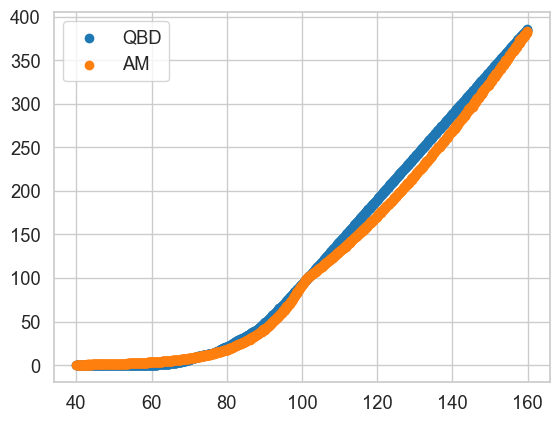

In [121]:
plt.scatter(test_,pr,label='QBD', )
plt.scatter(test_,test_answers, label='AM', )
plt.legend()
plt.show()

In [34]:
start = time.time()
pr = qbc_model(test_).detach().numpy()
end = time.time()

time_ = end-start
mse_ = mean_squared_error(pr,test_answers)
r2_ = r2_score(pr,test_answers)

inference_time['QBD_aggr'] = [time_]
mse['QBD_aggr'] = [mse_]
r2['QBD_aggr'] = [r2_]

In [ ]:
mse

# CAS4DL

In [ ]:
from DNN_sampling import run

In [ ]:
train_answers = train_answers.reshape(-1,1)
test_answers = test_answers.reshape(-1,1)

In [ ]:
train_answers

In [ ]:
cas_model,cas_mse,cas_mse,cas_r2,cas_t = run(l_bounds, u_bounds, 32, f ,train_points, train_answers, test_points, test_answers, 'ASGD')

In [ ]:
#test_ = torch.Tensor(test_points)
#preds = []
start = time.time()
pr = cas_model(test_points)
time_ = time.time()-start

#time_ = end-start
mse_ = mean_squared_error(pr,test_answers)
r2_ = r2_score(pr.numpy(),test_answers)

inference_time['CAS4DL'] = [time_]
mse['CAS4DL'] = [mse_]
r2['CAS4DL'] = [r2_]

# start = time.time()
# pr = mc_model(test_points)
# end = time.time()

# time_ = end-start
# mse_ = mean_squared_error(pr,test_answers)
# r2_ = r2_score(pr.numpy(),test_answers)

# inference_time['Uniform NN'] = [time_]
# mse['Uniform NN'] = [mse_]
# r2['Uniform NN'] = [r2_]

# NN

In [50]:
from environment import Environment
from ddpg_fol.ddpg import DDPG
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

In [51]:
from importlib import reload 
import environment
environment = reload(environment)
from environment import Environment

In [52]:
from numba import njit
import numpy as np
from warnings import filterwarnings

filterwarnings("ignore")

@njit
def sample_wiener_process_one_path(
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates one realization of a Wiener process (Brownian motion).

      Parameters:
      - time_deltas (np.ndarray): Array of time intervals between grid points = np.diff(time_grid).
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array representing the generated Wiener process path.

      Note: This function utilizes the `numba` library's JIT (Just-In-Time) compilation for improved
      performance. Ensure `numba` is installed in your environment.
    """
    normals = np.random.normal(0, sigma, len(time_deltas))
    result = np.zeros(len(time_deltas) + 1, dtype=float)
    result[1:] = np.cumsum(normals * np.sqrt(time_deltas))
    return result


@njit
def sample_wiener_process(
        number_of_simulations: int,
        time_deltas: np.ndarray,
        sigma: float
) -> np.ndarray:
    """
      Generates some realizations of a Wiener process (Brownian motion).

      Parameters:
      - number_of_simulations (int): number of paths to generate
      - time_deltas (np.ndarray): Array of time intervals between successive observations.
      - sigma (float): The volatility (standard deviation) of the Wiener process.

      Returns:
      np.ndarray: An array, each row representing the generated Wiener process trajectory.
    """
    result = np.zeros((number_of_simulations, len(time_deltas) + 1), dtype=float)
    for i in range(number_of_simulations):
        result[i] = sample_wiener_process_one_path(time_deltas, sigma)
    return result


def transform_to_monomials_degree_3(
        x: np.ndarray
) -> np.ndarray:
    """
      Transforms input features to all monomials degree <= 3

      Parameters:
      - x (np.ndarray): Input feature matrix of shape (n_samples, n_features).

      Returns:
      - transformed (np.ndarray): Array to store the transformed features, shape (n_samples, (n_features + 1) * (n_features + 2) // 2).
    """
    index = 0
    transformed = np.zeros((x.shape[0],
                            (x.shape[1] + 1) * (x.shape[1] + 2) // 2 + (x.shape[1] + 1) * (x.shape[1] + 2) * (
                                    x.shape[1] + 3) // 6
                            ), dtype=float)
    # triple-wise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            for k in range(j, x.shape[1]):
                transformed.T[index] = x.T[i] * x.T[j] * x.T[k]
                index += 1
    # pairwise product
    for i in range(x.shape[1]):
        for j in range(i, x.shape[1]):
            transformed.T[index] = x.T[i] * x.T[j]
            index += 1
    # repeat features
    for i in range(x.shape[1]):
        transformed.T[index] = x.T[i]
    # constant feature
    transformed.T[-1] = 1.
    return transformed


def f(
        assets0: np.ndarray,
) -> float:
    """
      Calculates bermudan call option with underlying max(asset_1, asset_2, ...) and strike_t = 0, asset_i --- Wiener process

      Parameters:
      - assets0 (np.ndarray): assets at the time 0
      Returns:
      float: option price

      time_grid = np.linspace(0., 1., 31)
      sigmas = 10.
      number_of_simulations = 2 ** 13
      strike = 100.
    """
    # init
    assets0 = assets0*60+100
    number_of_simulations = 2 ** 13
    t = 10
    time_grid = np.array(list(range(365 * t + 1)))
    time_grid = time_grid[np.where(np.logical_or(time_grid % 7 == 1, time_grid % 7 == 0))] / 365
    time_deltas = np.diff(time_grid)
    number_of_steps = len(time_deltas)
    discount_rate = 0.1

    # sampling
    discount_factor = np.exp(-discount_rate * time_grid)
    strike = np.ones(number_of_steps + 1, dtype=float) * 100. * discount_factor
    number_of_assets = len(assets0)
    sigmas = np.ones_like(assets0, dtype=float) * 10.
    assets = np.zeros((number_of_assets, number_of_simulations, number_of_steps + 1), dtype=float)
    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    # AMC
    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    regularization_alpha = 1e-2
    weights = [None] * (number_of_steps + 1)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            regularization = np.eye(transformed.shape[1], dtype=float) * regularization_alpha
            inv = np.linalg.pinv((transformed.T @ transformed + regularization), rcond=1e-4)
            weights[time_index] = inv @ transformed.T @ option_price[in_the_money_indices].reshape(-1, 1)
            continuation_value = transformed @ weights[-1]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    for i in range(len(sigmas)):
        assets[i] = (sample_wiener_process(number_of_simulations, time_deltas, sigmas[i]) + assets0[i]) * discount_factor

    option_price = np.clip(np.max(assets[:, :, -1], axis=0) - strike[-1], 0, 1e15)
    for time_index in range(number_of_steps, -1, -1):
        current_payoff = np.clip(np.max(assets[:, :, time_index], axis=0) - strike[time_index], 0, 1e15)
        if time_index == 0:
            continuation_value = np.ones(number_of_simulations) * np.mean(option_price)
            in_the_money_indices = np.arange(number_of_simulations, dtype=int)
        else:
            in_the_money_indices = np.where(current_payoff > 1e-6)[0]
            if len(in_the_money_indices) < 20 or weights[time_index] is None:
                continue
            features = assets[:, in_the_money_indices, time_index].T
            transformed = transform_to_monomials_degree_3(features)
            continuation_value = transformed @ weights[time_index]

        indicator = current_payoff[in_the_money_indices] > continuation_value.reshape(-1)
        option_price[in_the_money_indices] = \
            indicator * current_payoff[in_the_money_indices] + (~indicator) * continuation_value.reshape(-1)

    return np.array([np.mean(option_price)/400])

train_points = (np.load('X_train_new.npy')[idx]-100)/60
train_answers = np.load('y_train_new.npy')[idx]/400

test_points = (np.load('X_test_new.npy')-100)/60
test_answers = np.load('y_test_new.npy')/400

In [53]:
train_points = np.concatenate((train_points,[[0]]*16))
train_answers = []
for i in train_points:
    train_answers.append( f(np.array(i)))

In [54]:
train_answers = np.array(train_answers)

In [55]:
n_add = 30

In [56]:
class Arg:
    def __init__(self,):
        self.mode = 'test'
        self.hidden1 = 16
        self.hidden2 = 16
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_GP'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=4000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 20
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP')

In [57]:
# env = Environment(X = train_points,y = train_answers,l_bounds = [-1],u_bounds = [1],func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='last_points',N_state=20)
l_bounds = [-1,]
u_bounds = [1,]
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='last_points',n_tr=4)

state = env.reset()
agent.is_training = False

m = []
r = []
t = []
model = env.mod()
m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))
for i in range(n_add):
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))

MSE['RLGP_points'] = np.array(m)

In [58]:
pointss['RLGP_points'] = np.array(env.X[:19]*60+100).reshape(1,-1)

In [59]:
start = time.time()
pr = model.gpr.predict(test_points)
end = time.time()


time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers.flatten()*400)
mse['RLGP_points'] = [mse_]
inference_time['RLGP_points'] = [time_]

In [60]:
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='last_points',n_tr=4)
state = env.reset()
agent.is_training = False
test_ = torch.Tensor(test_points)

m = []
r = []
t = []
model = env.mod()
m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))
for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            stop = time.time()    
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_)*400,test_answers.flatten()*400))
            t.append(stop-start)

MSE['RLNN_points'] = np.array(m)

In [61]:
pointss['RLNN_points'] = np.array(env.X[:19]*60+100).reshape(1,-1)

In [62]:
start = time.time()
pr = model.predict(test_)
end = time.time()


time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers.flatten()*400)
mse['RLNN_points'] = [mse_]
inference_time['RLNN_points'] = [time_]

In [63]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=60
        self.validate_steps=500
        self.output='output_GP+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=10000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 40
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP+')

In [64]:
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                          func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='predictions+last_points',n_tr=4)

state = env.reset()
agent.is_training = False


m = []
r = []
t = []
model = env.mod()
m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))
for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))
            stop = time.time()    
            t.append(stop-start)

MSE['RLGP_points+prediction'] = np.array(m)

In [65]:
pointss['RLGP_points+prediction'] = np.array(env.X[:19]*60+100).reshape(1,-1)

In [66]:
start = time.time()
pr = model.gpr.predict(test_)
end = time.time()


time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers.flatten()*400)
mse['RLGP_points+prediction'] = [mse_]
inference_time['RLGP_points+prediction'] = [time_]

In [67]:
env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='predictions+last_points',n_tr=4)

state = env.reset()
print(state)
agent.is_training = False


m = []
r = []
t = []
model = env.mod()
m.append(mean_squared_error(model.predict(test_points)*400,test_answers.flatten()*400))
for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            #print(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_)*400,test_answers.flatten()*400))
            stop = time.time()    
            t.append(stop-start)

MSE['RLNN_points+prediction'] = np.array(m)

start = time.time()
pr = model.predict(test_)
end = time.time()


time_ = end-start
mse_ = mean_squared_error(pr*400,test_answers.flatten()*400)
mse['RLNN_points+prediction'] = [mse_]
inference_time['RLNN_points+prediction'] = [time_]

[-0.06187086 -0.05341454 -0.03484601 -0.00525769  0.0208914   0.03570623
  0.05891151  0.08365037  0.10764475  0.15887135  0.21764645  0.28931218
  0.35035145  0.3813467   0.40588424  0.41503757  0.43136454  0.45725417
  0.48687297  0.50697213 -0.58442367 -0.15741611 -0.52751346  0.17421107
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [ ]:
plt.scatter(test_,pr,label='QBD', )
plt.scatter(test_points,test_answers, label='AM', )
plt.legend()
plt.show()

In [69]:
MSE['RLNN_points+prediction'] = np.array(m)

In [71]:
mse['RLNN_points+prediction'] = [mse_]
inference_time['RLNN_points+prediction'] = [time_]

# Plots

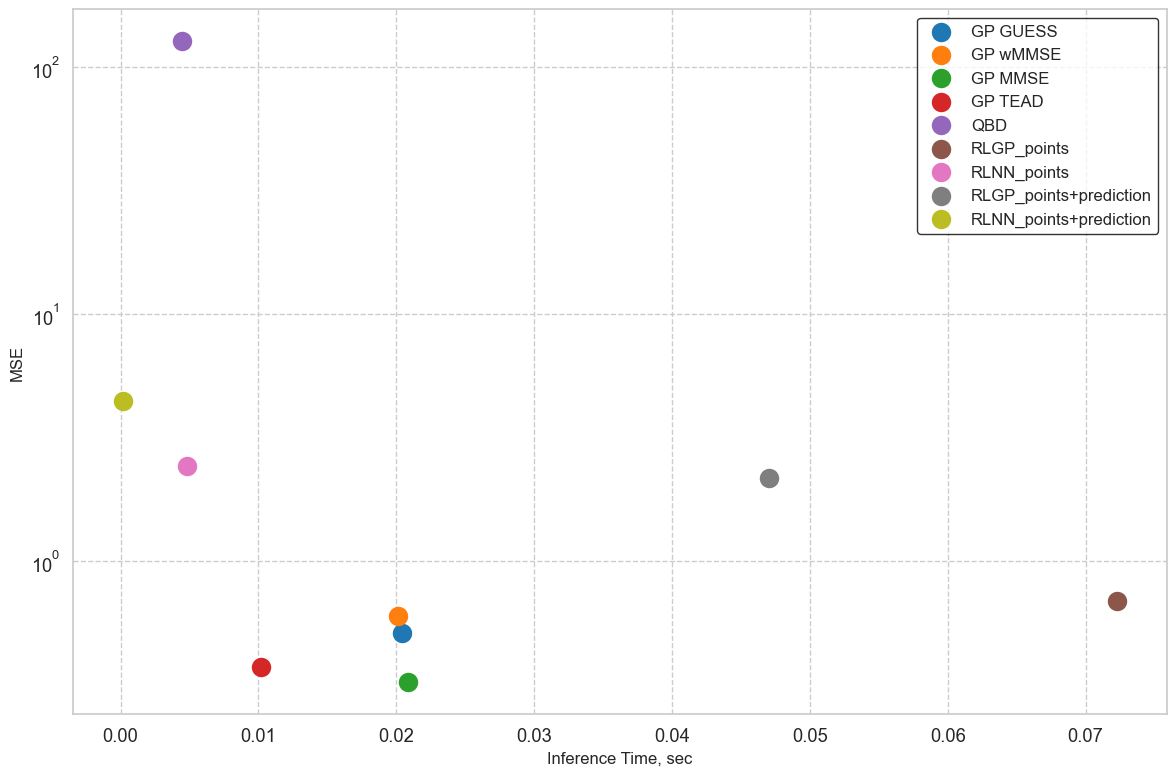

In [127]:
name =['GP GUESS','GP wMMSE','GP MMSE','GP TEAD','QBD','RLGP_points','RLNN_points','RLGP_points+prediction','RLNN_points+prediction']

fig, ax = plt.subplots(figsize=(12, 8))
i = 0
for col in name:
    ax.scatter(inference_time[col],mse[col], label=col, linewidths = 8)
    i+=1

ax.set_ylabel("MSE",fontsize=12)
ax.set_xlabel("Inference Time, sec",fontsize=12)
ax.set_yscale('log')
ax.grid(True, linestyle='--')
legend = ax.legend(loc='upper right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
#plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('4+30'+'.png')
plt.show()
#plt.tight_layout()
#plt.grid()
#plt.savefig('MSE_rainbow_1D'+'.png')
#plt.show() 

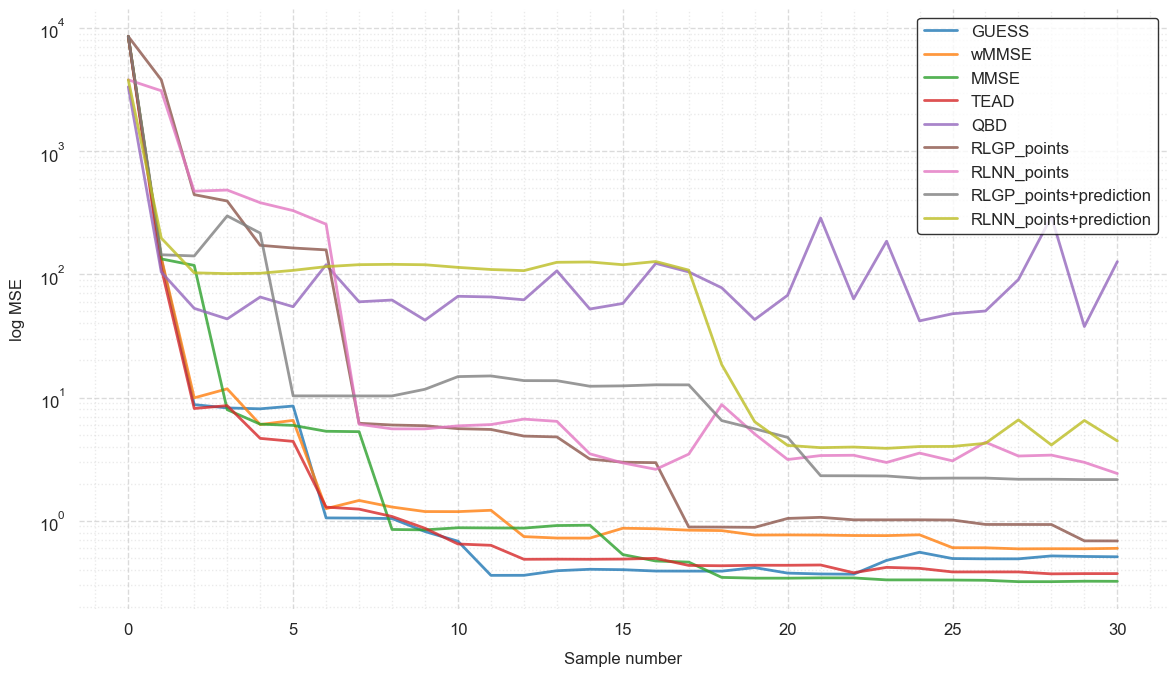

In [87]:
#name =['GUESS', 'wMMSE', 'MMSE', 'TEAD', 'QBD', 'RLGP_points+prediction', 'RLNN_points+prediction', 'RLGP_points', 'RLNN_points']
name =['GUESS','wMMSE','MMSE','TEAD','QBD','RLGP_points','RLNN_points','RLGP_points+prediction','RLNN_points+prediction']

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
methods =list(MSE.keys())

for method in name: 
    ax.plot(MSE[method][:],
            label=method, 
            linewidth=2.,
            alpha=0.8)

ax.set_xlabel('Sample number', labelpad=10, fontsize=12)
ax.set_yscale('log')
ax.set_ylabel('log MSE', labelpad=10, fontsize=12)
legend = ax.legend(loc='upper right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
plt.savefig('4+30_.png', dpi=300, bbox_inches='tight')


plt.show()